In [ ]:
# import os
# import json
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from datetime import datetime, timedelta
# import matplotlib.ticker as ticker
# import matplotlib as mpl
# import numpy as np
# import matplotlib.patches as mpatches

# # --------------------------------------------
# # Step 1: Load timing data from .jsonl files
# # --------------------------------------------

# def load_jsonl_timings(label, path, file):
#     file_path = os.path.join(path, file)
#     rows = []
#     if not os.path.exists(file_path):
#         print(f"No file at: {file_path}")
#         return rows

#     with open(file_path) as f:
#         for line in f:
#             try:
#                 data = json.loads(line)
#                 rows.append({
#                     "type": label,
#                     "start_ms": int(data["start_ms"]),
#                     "duration_ms": int(data["duration_ms"])
#                 })
#             except Exception as e:
#                 print(f"Failed to parse line: {e}")
#     return rows

# mpl.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": "Arial",
#     "font.size": 9,
#     "axes.titlesize": 10,
#     "axes.labelsize": 9,
#     "xtick.labelsize": 8,
#     "ytick.labelsize": 8,
#     "legend.fontsize": 8,
#     "figure.titlesize": 10,
# })

# # Color Accessibility Pallette Tool
# # https://gka.github.io/palettes/#/5|s|ffb000,fe6100,dc267f,785ef0,648fff|ffffe0,ff005e,93003a|0|1

# custom_colors = ['#ffb000', '#f86c36', '#dc267f', '#9d62d6', '#648fff', '#00bfc4', '#90d200']

# def run_analysis(label_to_path_dict, output_prefix, data_file):
#     rows = []
#     for label, path in label_to_path_dict.items():
#         rows += load_jsonl_timings(label, path, data_file)

#     df = pd.DataFrame(rows)
#     if df.empty:
#         print("⚠️ No timing data available. Skipping analysis.")
#         return

#     # Ensure experiments directory exists
#     base_dir = f"experiments/{output_prefix}"
#     os.makedirs(f"{base_dir}_plots", exist_ok=True)

#     # Save summary CSVs
#     df.to_csv(f"{base_dir}_timings_summary.csv", index=False)
#     print(f"✅ Saved timing summary to {base_dir}_timings_summary.csv")

#     df["start_time"] = pd.to_datetime(df["start_ms"], unit="ms")
#     summary_table = df.groupby("type")["duration_ms"].describe()
#     print(f"\n📊 Summary Table ({output_prefix}):")
#     print(summary_table)
#     summary_table.to_csv(f"{base_dir}_timings_stats.csv")

#     n_labels = df["type"].nunique()

#     # Histogram
#     plt.figure(figsize=(5.5, 4.5))

    # # Draw the Seaborn step histogram
    # sns.histplot(
    #     data=df,
    #     x="duration_ms",
    #     hue="type",
    #     element="step",
    #     bins=30,
    #     common_norm=False,
    #     stat="count",
    #     palette=custom_colors[:df["type"].nunique()],
    #     legend=False  # Disable the broken default legend
    # )

    # # Manually build the legend
    # handles = [
    #     mpatches.Patch(color=custom_colors[i], label=label)
    #     for i, label in enumerate(df["type"].unique())
    # ]

    # plt.title(r"\textbf{Distribution of Execution Times}")
    # plt.xlabel("Duration (ms)")
    # plt.ylabel("Count")

    # # Place legend at the bottom, 1 column per label
    # plt.legend(
    #     handles=handles,
    #     loc="upper center",
    #     bbox_to_anchor=(0.5, -0.2),
    #     ncol=len(handles),
    #     frameon=False
    # )

    # plt.tight_layout()
    # plt.savefig(f"{base_dir}_plots/histogram.pdf", bbox_inches="tight")
    # plt.close()

    # # Boxplot
    # plt.figure(figsize=(5.5, 4))  # widened from 4.5
    # sns.boxplot(data=df, x="type", y="duration_ms", palette=custom_colors)
    # plt.title(r"\textbf{Duration Variation}")
    # plt.ylabel("Duration (ms)")
    # plt.xlabel("")
    # plt.xticks(rotation=30)
    # plt.tight_layout()
    # plt.savefig(f"{base_dir}_plots/boxplot.pdf", bbox_inches="tight")
    # plt.close()


    # # Violin plot
    # plt.figure(figsize=(5.5, 3.5))  # widened from 3.5 to 5.5
    # sns.violinplot(data=df, x="type", y="duration_ms", inner="box", palette=custom_colors)
    # plt.title(r"\textbf{Density and Spread}")
    # plt.ylabel("Duration (ms)")
    # plt.xlabel("")
    # plt.xticks(rotation=30)
    # plt.tight_layout()
    # plt.savefig(f"{base_dir}_plots/violinplot.pdf", bbox_inches="tight")
    # plt.close()


    # # CDF
    # plt.figure(figsize=(4.5, 3))
    # for i, label in enumerate(df['type'].unique()):
    #     subset = df[df['type'] == label]['duration_ms'].sort_values()
    #     cum_prob = range(1, len(subset) + 1)
    #     plt.plot(subset, [x / len(subset) for x in cum_prob], label=label, color=custom_colors[i % len(custom_colors)])
    # plt.title(r"\textbf{Cumulative Distribution}")
    # plt.xlabel("Duration (ms)")
    # plt.ylabel("Cumulative Probability")
    # plt.legend(title=None, loc='upper center',  bbox_to_anchor=(0.5, -0.2), ncol=n_labels)
    # plt.tight_layout()
    # plt.savefig(f"{base_dir}_plots/cdf.pdf", bbox_inches="tight")
    # plt.close()


    # # Trend
    # # Group-wise normalization of elapsed time
    # df["elapsed_sec"] = df.groupby("type")["start_time"].transform(lambda x: (x - x.min()).dt.total_seconds())

    # plt.figure(figsize=(5.5, 4))
    # for i, label in enumerate(df["type"].unique()):
    #     sub_df = df[df["type"] == label]
    #     plt.plot(
    #         sub_df["elapsed_sec"],
    #         sub_df["duration_ms"],
    #         label=label,
    #         linewidth=1,
    #         color=custom_colors[i % len(custom_colors)]
    #     )

    # plt.legend(title=None, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=n_labels)
    # plt.title(r"\textbf{Execution Time Trends}")
    # #plt.xlim(0, df["elapsed_sec"].max())
    # plt.xlabel("Elapsed Time (s)")
    # plt.ylabel("Duration (ms)")
    # plt.tight_layout()
    # plt.savefig(f"{base_dir}_plots/trend.pdf", bbox_inches="tight")
    # plt.close()

    # # Order bars consistently in summary stats
    # type_order = df["type"].drop_duplicates().tolist()
    # means = df.groupby("type")["duration_ms"].mean().reindex(type_order)
    # stds = df.groupby("type")["duration_ms"].std().reindex(type_order)


    # # Bar chart with error bars
    # plt.figure(figsize=(5.5, 3.5))  # widened from 3.5
    # plt.bar(type_order, means.values, yerr=stds.values, capsize=4, color=custom_colors[:len(type_order)])
    # plt.title(r"\textbf{Mean Duration with Std. Dev.}")
    # plt.ylabel("Duration (ms)")
    # plt.xlabel("")
    # plt.xticks(rotation=30)
    # plt.tight_layout()
    # plt.savefig(f"{base_dir}_plots/means_with_error.pdf", bbox_inches="tight")
    # plt.close()

#     # Outliers
#     print(f"\n📉 Outliers in {output_prefix} (> 2 std dev):")
#     for label in df['type'].unique():
#         subset = df[df['type'] == label]
#         mu = subset["duration_ms"].mean()
#         sigma = subset["duration_ms"].std()
#         outliers = subset[subset["duration_ms"] > mu + 2 * sigma]
#         if not outliers.empty:
#             print(f"\nOutliers in {label}:")
#             print(outliers[["start_ms", "duration_ms"]])

# # This measures proof generation, proof verification, and latency for normal anonymous messages
# # Note latency includes proof verification time
# # ---- Core zk-timing results ----
# core_paths = {
#     "proof_gen": "json_files/1",
#     "proof_verify": "json_files/2",
#     "latency": "json_files/3"
# }
# run_analysis(core_paths, output_prefix="core", data_file="timings.jsonl")

# # This measures the proof generation time for all features
# # ---- Feature-based results ----
# feature_paths = {
#     "author": "json_files/author",
#     "rate_pseudo": "json_files/rate_pseudo",
#     "pseudo_msg": "json_files/pseudo_msg",
#     "pseudo_vote": "json_files/pseudo_vote",
#     "badge": "json_files/badge"
# }
# run_analysis(feature_paths, output_prefix="features", data_file="timings.jsonl")

# # This measures the latency for all features
# # Note latency includes proof verification time
# latency_feature_paths = {
#     "author": "json_files/author",
#     "rate_pseudo": "json_files/rate_pseudo",
#     "pseudo_msg": "json_files/pseudo_msg",
#     "pseudo_vote": "json_files/pseudo_vote",
#     "badge": "json_files/badge",
#     "ban": "json_files/ban", 
#     "rep": "json_files/rep"
# }
# run_analysis(latency_feature_paths, output_prefix="latency_features", data_file="features_timings.jsonl")

# # This graph is just for showing the latency of ban and rep since they act more linearly (maybe n log n) not sure yet
# ban_rep_paths = {
#     "ban": "json_files/ban", 
#     "rep": "json_files/rep"
# }
# run_analysis(ban_rep_paths, output_prefix="ban_rep", data_file="features_timings.jsonl")

✅ Saved timing summary to experiments/core_timings_summary.csv

📊 Summary Table (core):
              count    mean        std     min      25%     50%      75%  \
type                                                                       
latency        10.0   246.0   9.404491   229.0   241.50   250.0   250.75   
proof_gen      10.0  1624.8  15.046594  1602.0  1613.50  1625.0  1637.00   
proof_verify   10.0   125.8   7.099296   113.0   122.25   128.5   130.75   

                 max  
type                  
latency        257.0  
proof_gen     1647.0  
proof_verify   133.0  


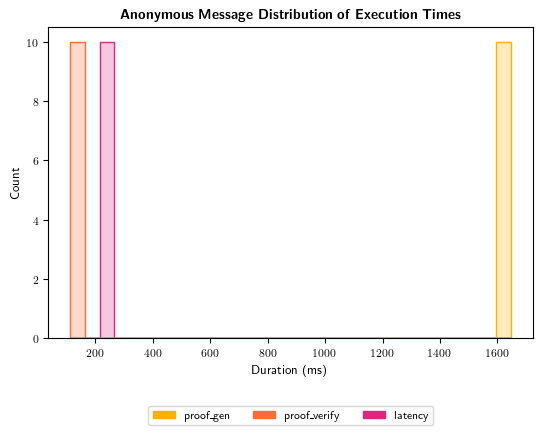

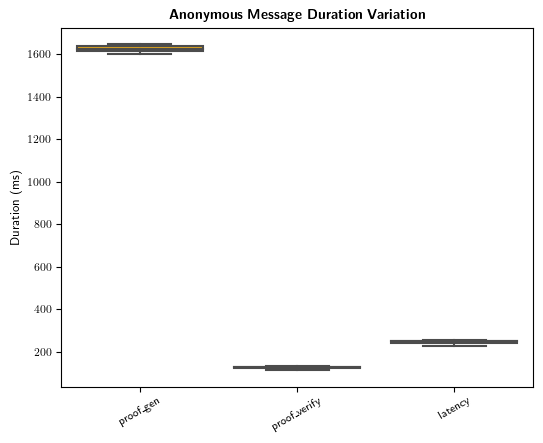

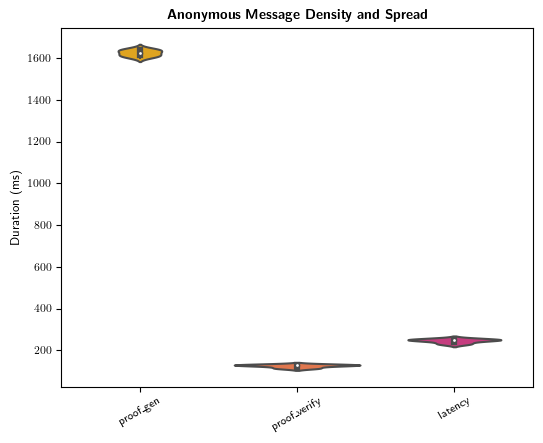

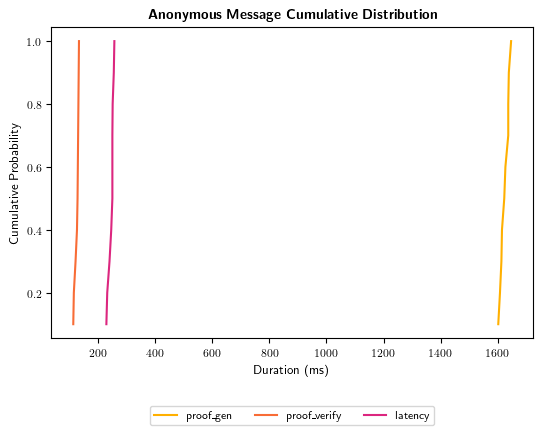

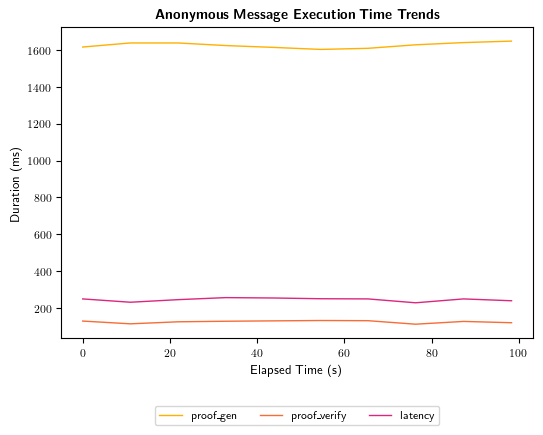

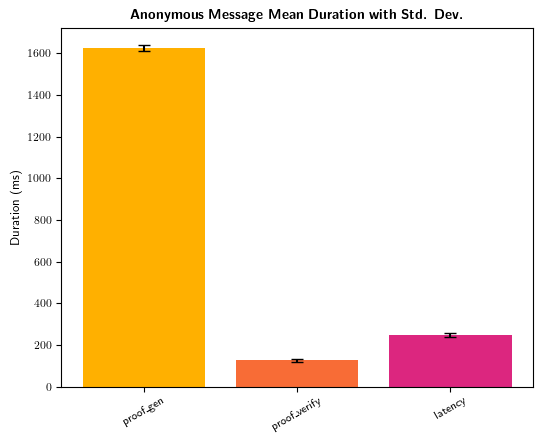


📉 Outliers in core (> 2 std dev):
✅ Saved timing summary to experiments/features_timings_summary.csv

📊 Summary Table (features):
             count    mean        std     min      25%     50%      75%  \
type                                                                      
author        10.0  1477.3  17.863992  1452.0  1463.50  1472.5  1494.75   
badge         10.0  1363.2  23.332381  1334.0  1344.50  1362.5  1376.50   
pseudo_msg    10.0  1656.2  17.781389  1640.0  1649.25  1651.0  1652.75   
pseudo_vote   10.0  1430.2  31.346806  1407.0  1410.25  1414.0  1438.50   
rate_pseudo   10.0  1695.3  14.298796  1683.0  1683.00  1690.5  1703.00   

                max  
type                 
author       1502.0  
badge        1401.0  
pseudo_msg   1703.0  
pseudo_vote  1489.0  
rate_pseudo  1725.0  


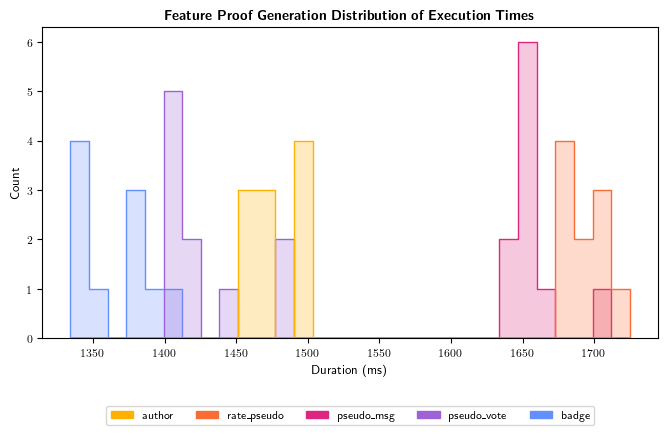

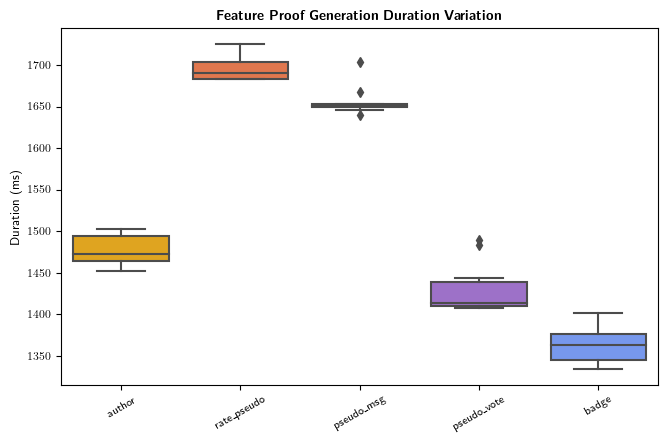

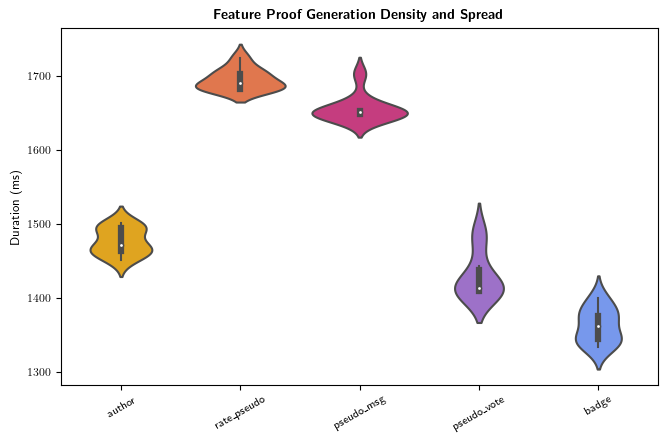

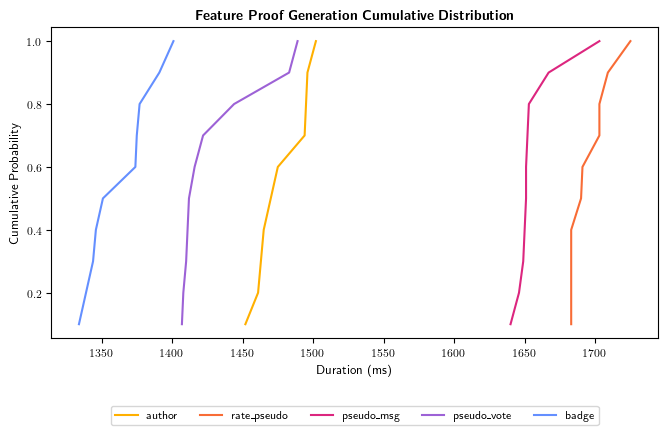

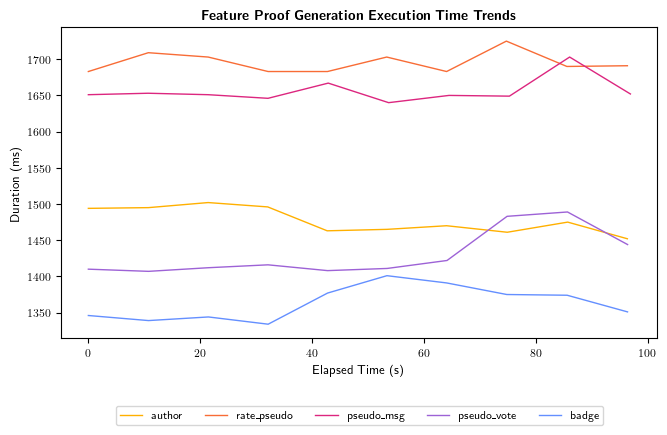

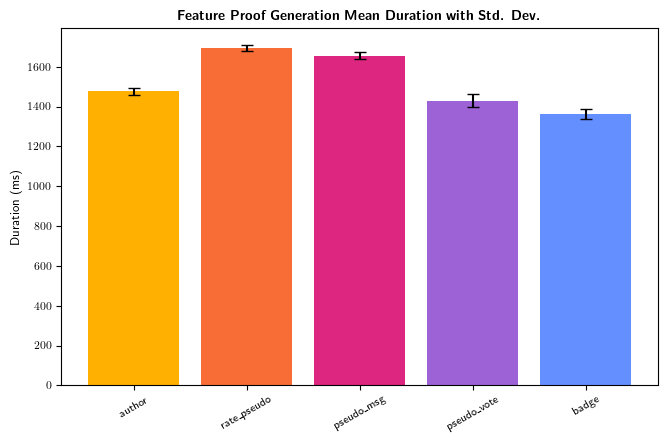


📉 Outliers in features (> 2 std dev):

Outliers in rate_pseudo:
         start_ms  duration_ms
17  1748534791948         1725

Outliers in pseudo_msg:
         start_ms  duration_ms
28  1748534584809         1703
✅ Saved timing summary to experiments/latency_features_timings_summary.csv

📊 Summary Table (latency_features):
             count   mean        std    min     25%    50%     75%    max
type                                                                     
author        10.0  200.4  12.176480  190.0  194.00  197.0  200.75  232.0
badge         10.0  192.0  10.143416  178.0  188.25  190.5  192.75  217.0
ban           10.0  103.9  30.171547   67.0   75.00  109.0  131.50  140.0
pseudo_msg    10.0  250.5  14.774227  218.0  250.50  254.5  256.75  267.0
pseudo_vote   10.0  191.2  19.429645  157.0  184.00  188.5  200.00  231.0
rate_pseudo   10.0  256.7   3.622461  253.0  253.00  256.5  259.75  262.0
rep           10.0  191.6  26.403703  159.0  174.50  188.0  209.50  238.0


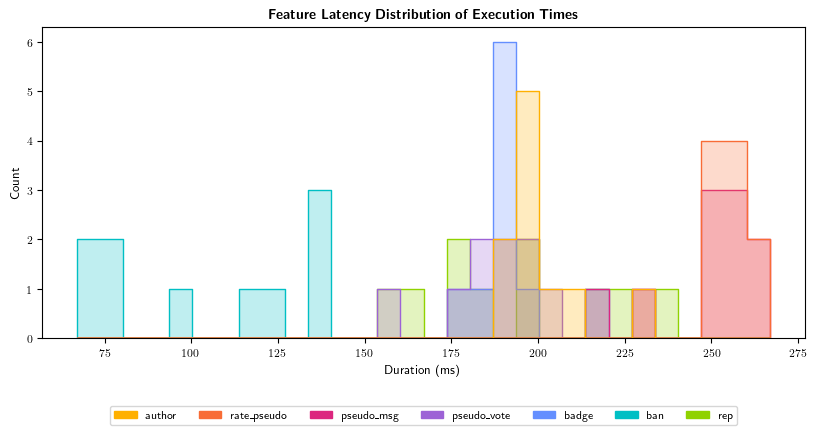

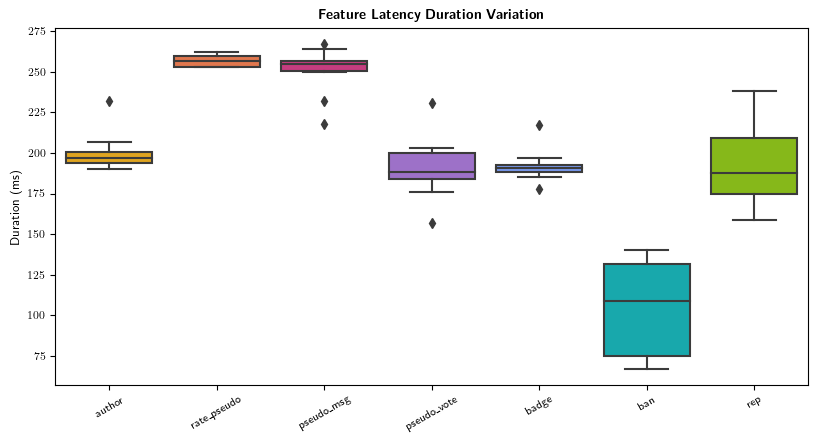

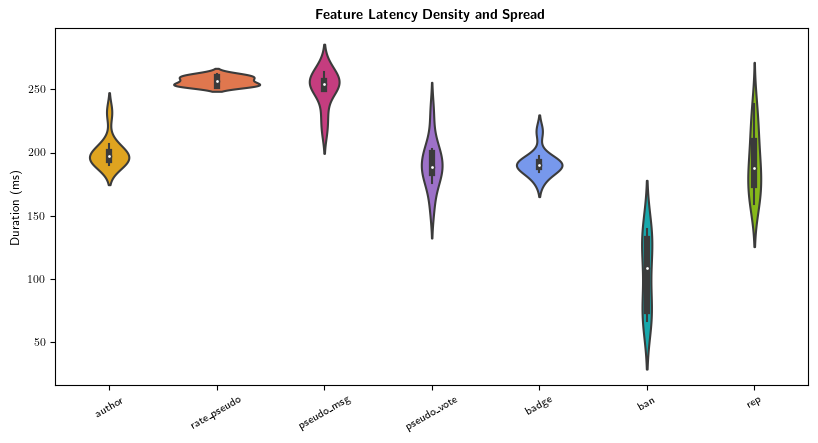

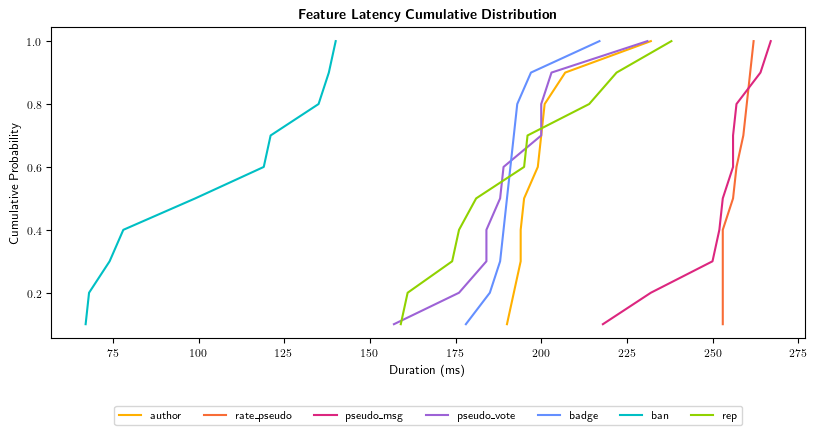

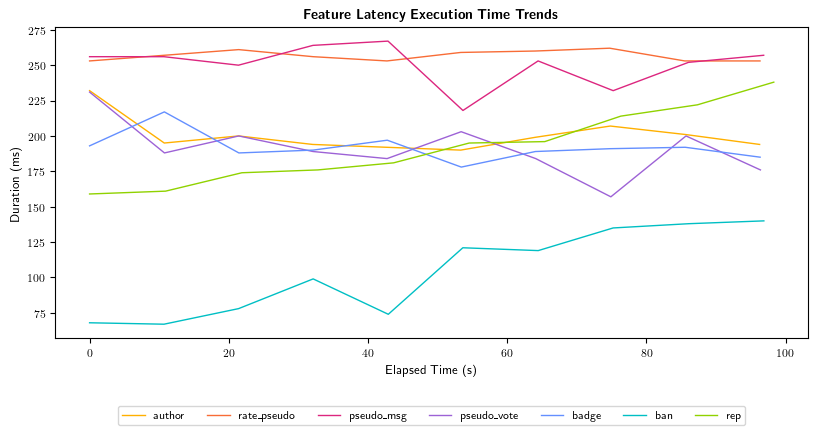

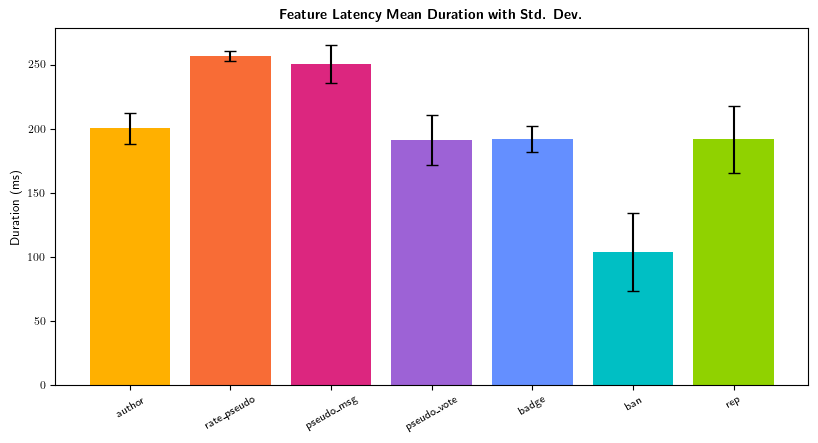


📉 Outliers in latency_features (> 2 std dev):

Outliers in author:
        start_ms  duration_ms
0  1748534726925          232

Outliers in pseudo_vote:
         start_ms  duration_ms
30  1748534724408          231

Outliers in badge:
         start_ms  duration_ms
41  1748534732074          217
✅ Saved timing summary to experiments/ban_rep_timings_summary.csv

📊 Summary Table (ban_rep):
      count   mean        std    min    25%    50%    75%    max
type                                                            
ban    10.0  103.9  30.171547   67.0   75.0  109.0  131.5  140.0
rep    10.0  191.6  26.403703  159.0  174.5  188.0  209.5  238.0


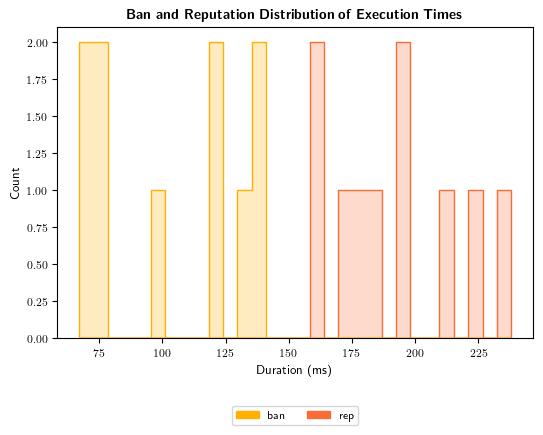

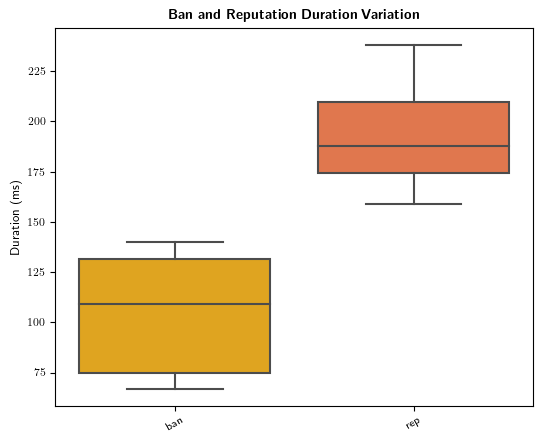

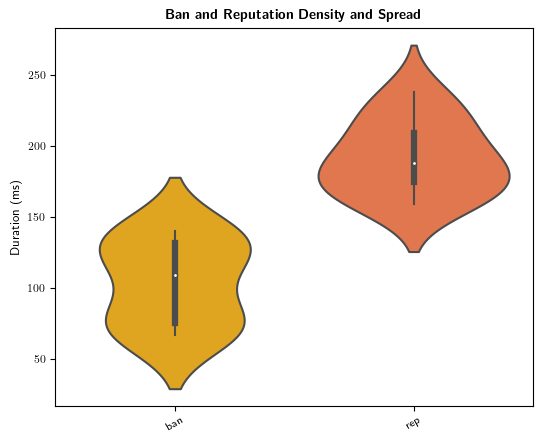

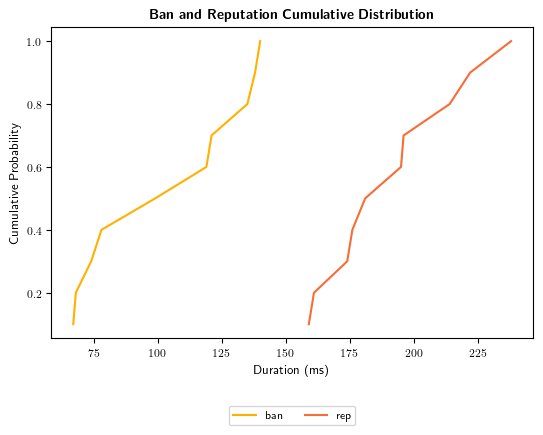

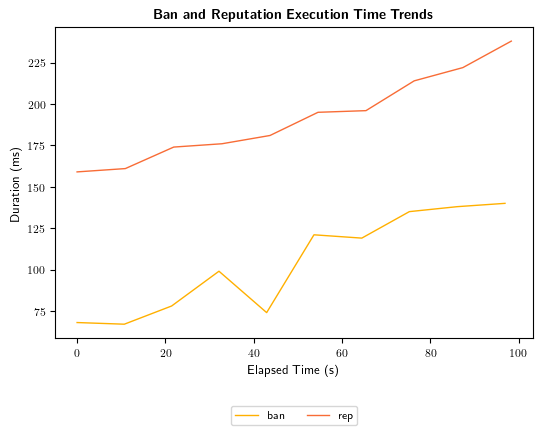

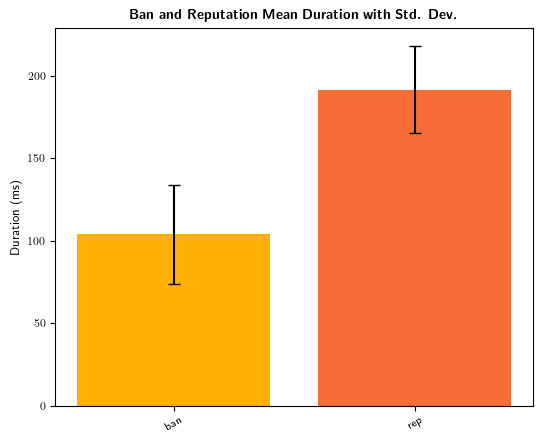


📉 Outliers in ban_rep (> 2 std dev):


In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.ticker as ticker
import matplotlib as mpl
import numpy as np
import matplotlib.patches as mpatches

# --------------------------------------------
# Step 1: Load timing data from .jsonl files
# --------------------------------------------

def load_jsonl_timings(label, path, file):
    file_path = os.path.join(path, file)
    rows = []
    if not os.path.exists(file_path):
        print(f"No file at: {file_path}")
        return rows

    with open(file_path) as f:
        for line in f:
            try:
                data = json.loads(line)
                rows.append({
                    "type": label,
                    "start_ms": int(data["start_ms"]),
                    "duration_ms": int(data["duration_ms"])
                })
            except Exception as e:
                print(f"Failed to parse line: {e}")
    return rows
# Matplotlib vector-friendly and font embedding settings
mpl.rcParams.update({
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "text.usetex": True,
    "pgf.texsystem": "pdflatex",
    "font.family": "sans-serif",
    "font.sans-serif": "Arial",
    "font.size": 9,
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    "figure.titlesize": 10,
    "pgf.rcfonts": False
})

# Color Accessibility Pallette Tool
custom_colors = ['#ffb000', '#f86c36', '#dc267f', '#9d62d6', '#648fff', '#00bfc4', '#90d200']

def autosize(n_labels):
    width = max(5.5, 3 + 0.75 * n_labels)
    height = 4.5
    return (width, height)

def save_plot(fig, path_without_ext):
    fig.savefig(f"{path_without_ext}.pdf", bbox_inches="tight")
    fig.savefig(f"{path_without_ext}.pgf", bbox_inches="tight")

def run_analysis(label_to_path_dict, output_prefix, data_file, custom_title_prefix=""):
    rows = []
    for label, path in label_to_path_dict.items():
        rows += load_jsonl_timings(label, path, data_file)

    df = pd.DataFrame(rows)
    if df.empty:
        print("⚠️ No timing data available. Skipping analysis.")
        return

    base_dir = f"experiments/{output_prefix}"
    os.makedirs(f"{base_dir}_plots", exist_ok=True)

    df.to_csv(f"{base_dir}_timings_summary.csv", index=False)
    print(f"✅ Saved timing summary to {base_dir}_timings_summary.csv")

    df["start_time"] = pd.to_datetime(df["start_ms"], unit="ms")
    summary_table = df.groupby("type")["duration_ms"].describe()
    print(f"\n📊 Summary Table ({output_prefix}):")
    print(summary_table)
    summary_table.to_csv(f"{base_dir}_timings_stats.csv")

    n_labels = df["type"].nunique()
    size = autosize(n_labels)

    # Histogram
    fig = plt.figure(figsize=size)
    sns.histplot(
        data=df,
        x="duration_ms",
        hue="type",
        element="step",
        bins=30,
        common_norm=False,
        stat="count",
        palette=custom_colors[:n_labels],
        legend=False
    )
    handles = [
        mpatches.Patch(color=custom_colors[i], label=label)
        for i, label in enumerate(df["type"].unique())
    ]
    plt.title(rf"\textbf{{{custom_title_prefix} Distribution of Execution Times}}")
    plt.xlabel("Duration (ms)")
    plt.ylabel("Count")
    plt.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=len(handles))
    plt.tight_layout()
    save_plot(fig, f"{base_dir}_plots/histogram")
    plt.show()
    plt.close()

    # Boxplot
    fig = plt.figure(figsize=size)
    sns.boxplot(data=df, x="type", y="duration_ms", palette=custom_colors)
    plt.title(rf"\textbf{{{custom_title_prefix} Duration Variation}}")
    plt.ylabel("Duration (ms)")
    plt.xlabel("")
    plt.xticks(rotation=30)
    plt.tight_layout()
    save_plot(fig, f"{base_dir}_plots/boxplot")
    plt.show()
    plt.close()

    # Violin plot
    fig = plt.figure(figsize=size)
    sns.violinplot(data=df, x="type", y="duration_ms", inner="box", palette=custom_colors)
    plt.title(rf"\textbf{{{custom_title_prefix} Density and Spread}}")
    plt.ylabel("Duration (ms)")
    plt.xlabel("")
    plt.xticks(rotation=30)
    plt.tight_layout()
    save_plot(fig, f"{base_dir}_plots/violinplot")
    plt.show()
    plt.close()

    # CDF
    fig = plt.figure(figsize=size) #plt.figure(figsize=(4.5, 3.5))
    for i, label in enumerate(df['type'].unique()):
        subset = df[df['type'] == label]['duration_ms'].sort_values()
        cum_prob = range(1, len(subset) + 1)
        plt.plot(subset, [x / len(subset) for x in cum_prob], label=label, color=custom_colors[i % len(custom_colors)])
    plt.title(rf"\textbf{{{custom_title_prefix} Cumulative Distribution}}")
    plt.xlabel("Duration (ms)")
    plt.ylabel("Cumulative Probability")
    plt.legend(title=None, loc='upper center',  bbox_to_anchor=(0.5, -0.2), ncol=n_labels)
    plt.tight_layout()
    save_plot(fig, f"{base_dir}_plots/cdf")
    plt.show()
    plt.close()

    # Trend
    df["elapsed_sec"] = df.groupby("type")["start_time"].transform(lambda x: (x - x.min()).dt.total_seconds())
    fig = plt.figure(figsize=size)
    for i, label in enumerate(df["type"].unique()):
        sub_df = df[df["type"] == label]
        plt.plot(
            sub_df["elapsed_sec"],
            sub_df["duration_ms"],
            label=label,
            linewidth=1,
            color=custom_colors[i % len(custom_colors)]
        )
    plt.legend(title=None, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=n_labels)
    plt.title(rf"\textbf{{{custom_title_prefix} Execution Time Trends}}")
    plt.xlabel("Elapsed Time (s)")
    plt.ylabel("Duration (ms)")
    plt.tight_layout()
    save_plot(fig, f"{base_dir}_plots/trend")
    plt.show()
    plt.close()

    # Bar chart with error bars
    type_order = df["type"].drop_duplicates().tolist()
    means = df.groupby("type")["duration_ms"].mean().reindex(type_order)
    stds = df.groupby("type")["duration_ms"].std().reindex(type_order)
    fig = plt.figure(figsize=size)
    plt.bar(type_order, means.values, yerr=stds.values, capsize=4, color=custom_colors[:len(type_order)])
    plt.title(rf"\textbf{{{custom_title_prefix} Mean Duration with Std. Dev.}}")
    plt.ylabel("Duration (ms)")
    plt.xlabel("")
    plt.xticks(rotation=30)
    plt.tight_layout()
    save_plot(fig, f"{base_dir}_plots/means_with_error")
    plt.show()
    plt.close()

    # Outliers
    print(f"\n📉 Outliers in {output_prefix} (> 2 std dev):")
    for label in df['type'].unique():
        subset = df[df['type'] == label]
        mu = subset["duration_ms"].mean()
        sigma = subset["duration_ms"].std()
        outliers = subset[subset["duration_ms"] > mu + 2 * sigma]
        if not outliers.empty:
            print(f"\nOutliers in {label}:")
            print(outliers[["start_ms", "duration_ms"]])

# Core
core_paths = {
    "proof_gen": "json_files/1",
    "proof_verify": "json_files/2",
    "latency": "json_files/3"
}
run_analysis(core_paths, output_prefix="core", data_file="timings.jsonl", custom_title_prefix="Anonymous Message")

# Features
feature_paths = {
    "author": "json_files/author",
    "rate_pseudo": "json_files/rate_pseudo",
    "pseudo_msg": "json_files/pseudo_msg",
    "pseudo_vote": "json_files/pseudo_vote",
    "badge": "json_files/badge"
}
run_analysis(feature_paths, output_prefix="features", data_file="timings.jsonl", custom_title_prefix="Feature Proof Generation")

# Latency Features
latency_feature_paths = {
    "author": "json_files/author",
    "rate_pseudo": "json_files/rate_pseudo",
    "pseudo_msg": "json_files/pseudo_msg",
    "pseudo_vote": "json_files/pseudo_vote",
    "badge": "json_files/badge",
    "ban": "json_files/ban", 
    "rep": "json_files/rep"
}
run_analysis(latency_feature_paths, output_prefix="latency_features", data_file="features_timings.jsonl", custom_title_prefix="Feature Latency")

# Ban and Rep
ban_rep_paths = {
    "ban": "json_files/ban", 
    "rep": "json_files/rep"
}
run_analysis(ban_rep_paths, output_prefix="ban_rep", data_file="features_timings.jsonl", custom_title_prefix="Ban and Reputation")
